In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
import colorcet
import seaborn as sns
import skimage.filters
from tqdm import tqdm

In [4]:
from wassersteinwormhole import Wormhole

In [5]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

import ott
from ott import problems
from ott.geometry import geometry, pointcloud, epsilon_scheduler
from ott.solvers import linear, quadratic
from ott.solvers.linear import acceleration, sinkhorn, sinkhorn_lr
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

# Load ModelNet data 

ModelNet40 data be downloaded from: https://github.com/antao97/PointCloudDatasets?tab=readme-ov-file

In [6]:
import pickle

with open('/data/peer/DoronHaviv/ModelNet40/pc_train.pickle', 'rb') as f:
    pc_train = pickle.load(f)

with open('/data/peer/DoronHaviv/ModelNet40/pc_test.pickle', 'rb') as f:
    pc_test = pickle.load(f)
    
train_labels = np.load('/data/peer/DoronHaviv/ModelNet40/train_labels.npy', allow_pickle = True)
test_labels = np.load('/data/peer/DoronHaviv/ModelNet40/test_labels.npy', allow_pickle = True)

## Show some examples

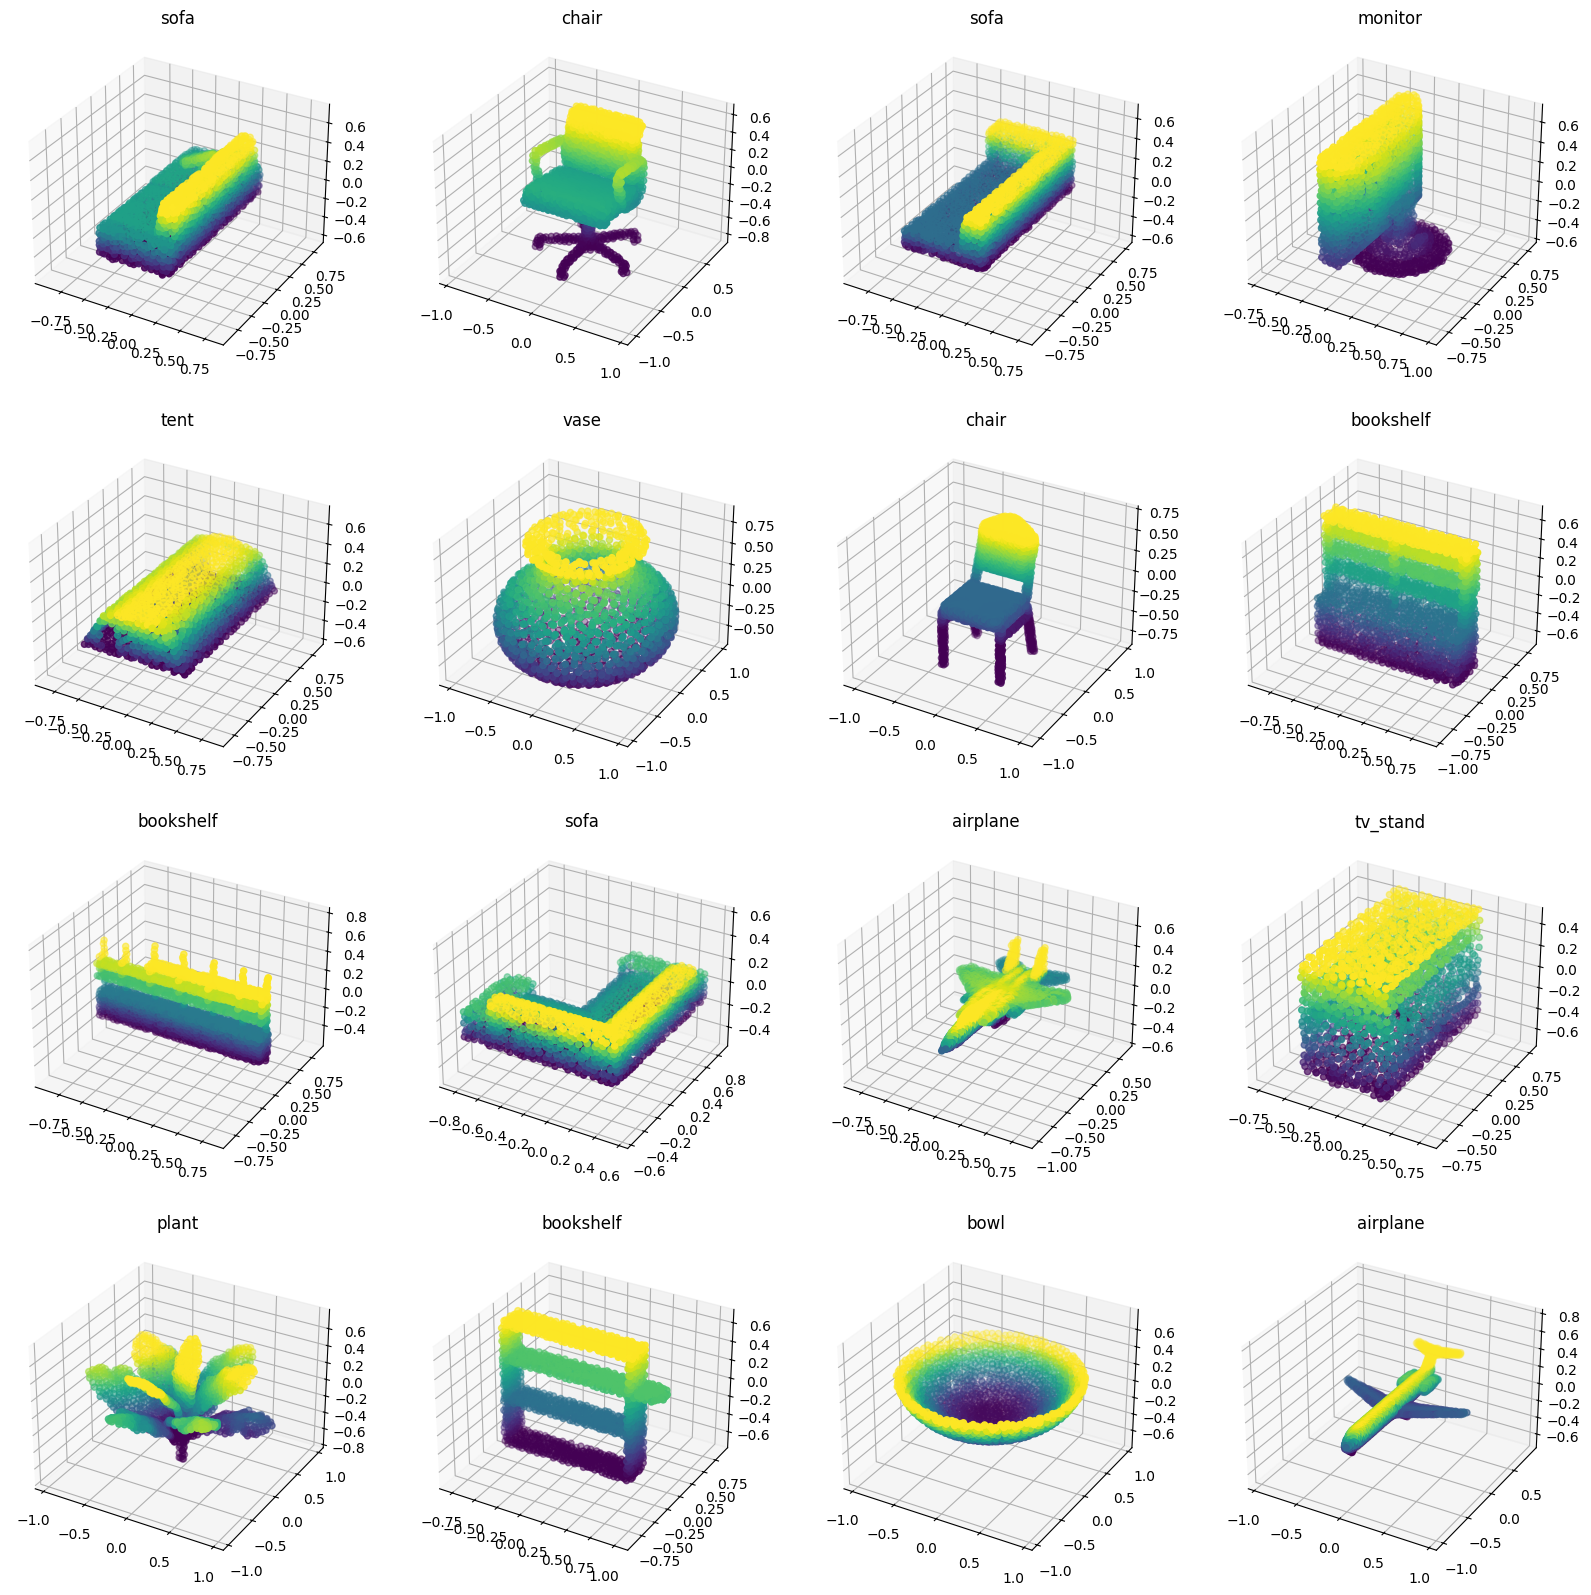

In [7]:
fig = plt.figure(figsize=(20, 20))

for ind in range(16):
    ax = fig.add_subplot(4,4,1+ind, projection='3d')
    i = np.random.randint(0, len(pc_train))
    ax.scatter(pc_train[i][:, 0], pc_train[i][:, 2], pc_train[i][:, 1],
               c = pc_train[i][:, 1], vmin = np.percentile(pc_train[i][:, 1], 10), vmax =  np.percentile(pc_train[i][:, 1], 90))
    plt.axis('equal')
    plt.title(train_labels[i])
plt.show()

# Time-Trails

Create subsampled datasets with 100, 300, 700, 1000, 5000, 7000, 9843 samples each

In [8]:
scale_sizes = [100, 300, 700, 1000, 5000, 7000, 9843]

scale_inds = []
for size in scale_sizes:
    scale_inds.append(np.random.choice(np.arange(len(pc_train)), size, replace = False))

We will now measure how long it takes for each method to approximate the pairwise wasserstein distance for each dataset scale

## Wormhole

In [9]:
wormhole_times = []

In [10]:
def wormhole_func(pc): 
    WormholeModel = Wormhole(point_clouds = pc)
    WormholeModel.train()
    embeddings = WormholeModel.encode(WormholeModel.point_clouds, WormholeModel.masks)
    return(embeddings)

In [ ]:
run_out = False
for inds in scale_inds:
    
    if(run_out):
         wormhole_times.append(18000)
    else:
        pc_scale = [pc_train[ind] for ind in inds]
        
        t_start = time.time()
        try:
            emb = wormhole_func(pc_scale)
        except TimeoutError:
            print("Run out of time")
            run_out = True
            
        t_ends = time.time()
        wormhole_times.append(t_ends - t_start)

 enc_loss: 1.909e-05 dec_loss: 1.091e-04 enc_corr: 0.998:  84%|████████▍ | 8448/10000 [40:34<07:10,  3.61it/s]

## Full Sinkhorn

In [ ]:
def S2(x, y, eps, lse_mode = False):
    x,a = x[0], x[1]
    y,b = y[0], y[1]
        
    ot_solve_xy = linear.solve(
        ott.geometry.pointcloud.PointCloud(x, y, cost_fn=None, epsilon = eps),
        a = a,
        b = b,
        lse_mode=lse_mode,
        min_iterations=0,
        max_iterations=100)

    ot_solve_xx = linear.solve(
    ott.geometry.pointcloud.PointCloud(x, x, cost_fn=None, epsilon = eps),
    a = a,
    b = a,
    lse_mode=lse_mode,
    min_iterations=0,
    max_iterations=100)
    
    ot_solve_yy = linear.solve(
    ott.geometry.pointcloud.PointCloud(y, y, cost_fn=None, epsilon = eps),
    a = b,
    b = b,
    lse_mode=lse_mode,
    min_iterations=0,
    max_iterations=100)
    return(ot_solve_xy.reg_ot_cost - 0.5 * ot_solve_xx.reg_ot_cost - 0.5 * ot_solve_yy.reg_ot_cost)

jit_s2 = jax.jit(jax.vmap(S2, (0, 0, None, None), 0), static_argnums=[2,3])   
        

In [ ]:
def normalize_pointclouds(point_clouds):
    min_val = np.min([pc.min() for pc in point_clouds])
    max_val = np.max([pc.max() for pc in point_clouds])
    
    return([2*(pc-min_val)/(max_val-min_val)-1 for pc in point_clouds])
    
def pad_pointclouds(point_clouds, max_shape = -1):
    if(max_shape == -1):
        max_shape = np.max([pc.shape[0] for pc in point_clouds])+1
    else:
        max_shape = max_shape + 1
    weight_vec = np.asarray([np.concatenate((np.ones(pc.shape[0]), np.zeros(max_shape - pc.shape[0])), axis = 0) for pc in point_clouds])
    point_clouds_pad = np.asarray([np.concatenate([pc, np.zeros([max_shape - pc.shape[0], pc.shape[-1]])], axis = 0) for pc in point_clouds])
    return(point_clouds_pad[:, :-1].astype('float32'), weight_vec[:, :-1].astype('float32'))

# @timeout(18000)
def sinkhorn_func(pc, batch_size = 256): 
    
    pc = normalize_pointclouds(pc)
    

    pc_padded, weight_vec = pad_pointclouds(pc)
    weight_vec = weight_vec/weight_vec.sum(axis = 1, keepdims = True)
    
    pairwise_ind = np.stack(np.triu_indices(len(pc), 1), axis = 1) 
    num_div = int(np.ceil(pairwise_ind.shape[0]/batch_size))
    
    
    ind_split = np.array_split(pairwise_ind, num_div)
    
    if(num_div < 100):
        t1 = time.time()
        true_w2 = [jit_s2([pc_padded[ind_batch[:, 0]], weight_vec[ind_batch[:, 0]]], 
                          [pc_padded[ind_batch[:, 1]], weight_vec[ind_batch[:, 1]]], 
                           0.1, False) for ind_batch in tqdm(ind_split)]
        t2 = time.time()
        return(t2 - t1)
    else:
        t1 = time.time()
        true_w2 = [jit_s2([pc_padded[ind_batch[:, 0]], weight_vec[ind_batch[:, 0]]], 
                  [pc_padded[ind_batch[:, 1]], weight_vec[ind_batch[:, 1]]], 
                   0.1, False) for ind_batch in tqdm(ind_split[:100])]
        t2 = time.time()
        return(((t2-t1)/100) * num_div)
    


In [ ]:
sinkhorn_times = []

In [ ]:
run_out = False
for inds in scale_inds:
    pc_scale = [pc_train[ind] for ind in inds]
    sinkhorn_times.append(sinkhorn_func(pc_scale))

## Sinkhorn LR

In [ ]:
def S2_LR(x, y, eps, lse_mode = False):
    x,a = x[0], x[1]
    y,b = y[0], y[1]
        
    ot_solve_xy = linear.solve(
        ott.geometry.pointcloud.PointCloud(x, y, cost_fn=None, epsilon = eps),
        a = a,
        b = b,
        lse_mode=lse_mode,
        rank = 10,
        min_iterations=0,
        max_iterations=100)

    ot_solve_xx = linear.solve(
    ott.geometry.pointcloud.PointCloud(x, x, cost_fn=None, epsilon = eps),
    a = a,
    b = a,
    lse_mode=lse_mode,
    rank = 10,
    min_iterations=0,
    max_iterations=100)
    
    ot_solve_yy = linear.solve(
    ott.geometry.pointcloud.PointCloud(y, y, cost_fn=None, epsilon = eps),
    a = b,
    b = b,
    lse_mode=lse_mode,
    rank = 10,
    min_iterations=0,
    max_iterations=100)
    return(ot_solve_xy.reg_ot_cost - 0.5 * ot_solve_xx.reg_ot_cost - 0.5 * ot_solve_yy.reg_ot_cost)

jit_s2_LR = jax.jit(jax.vmap(S2_LR, (0, 0, None, None), 0), static_argnums=[2,3])   
        

In [ ]:
def normalize_pointclouds(point_clouds):
    min_val = np.min([pc.min() for pc in point_clouds])
    max_val = np.max([pc.max() for pc in point_clouds])
    
    return([2*(pc-min_val)/(max_val-min_val)-1 for pc in point_clouds])
    
def pad_pointclouds(point_clouds, max_shape = -1):
    if(max_shape == -1):
        max_shape = np.max([pc.shape[0] for pc in point_clouds])+1
    else:
        max_shape = max_shape + 1
    weight_vec = np.asarray([np.concatenate((np.ones(pc.shape[0]), np.zeros(max_shape - pc.shape[0])), axis = 0) for pc in point_clouds])
    point_clouds_pad = np.asarray([np.concatenate([pc, np.zeros([max_shape - pc.shape[0], pc.shape[-1]])], axis = 0) for pc in point_clouds])
    return(point_clouds_pad[:, :-1].astype('float32'), weight_vec[:, :-1].astype('float32'))

def sinkhorn_lr_func(pc, batch_size = 256): 
    
    pc = normalize_pointclouds(pc)
    

    pc_padded, weight_vec = pad_pointclouds(pc)
    weight_vec = weight_vec/weight_vec.sum(axis = 1, keepdims = True)
    
    pairwise_ind = np.stack(np.triu_indices(len(pc), 1), axis = 1) 
    num_div = int(np.ceil(pairwise_ind.shape[0]/batch_size))
    
    
    ind_split = np.array_split(pairwise_ind, num_div)


    if(num_div < 100):
        t1 = time.time()
        true_w2 = [jit_s2_LR([pc_padded[ind_batch[:, 0]], weight_vec[ind_batch[:, 0]]], 
                          [pc_padded[ind_batch[:, 1]], weight_vec[ind_batch[:, 1]]], 
                           0.1, False) for ind_batch in tqdm(ind_split)]
        t2 = time.time()
        return(t2 - t1)
    else:
        t1 = time.time()
        true_w2 = [jit_s2_LR([pc_padded[ind_batch[:, 0]], weight_vec[ind_batch[:, 0]]], 
                  [pc_padded[ind_batch[:, 1]], weight_vec[ind_batch[:, 1]]], 
                   0.1, False) for ind_batch in tqdm(ind_split[:100])]
        t2 = time.time()
        return(((t2-t1)/100) * num_div)

In [ ]:
sinkhorn_lr_times = []

In [ ]:
run_out = False
for inds in scale_inds:
    pc_scale = [pc_train[ind] for ind in inds]
    sinkhorn_lr_times.append(sinkhorn_lr_func(pc_scale))

## MetaOT

### Convert Point Clouds to 3D voxels

In [ ]:
def voxelize(point_clouds, num_vox_per_axis):

    min_val = np.min([pc.min() for pc in point_clouds])
    max_val = np.max([pc.max() for pc in point_clouds])
        
    pc_norm_cord = [((num_vox_per_axis-1) * np.clip((pc-min_val)/(max_val - min_val), 0, 1)).astype('int') for pc in point_clouds]
    
    dim = point_clouds[0].shape[1]
    if(dim == 2):
        images = np.zeros([len(point_clouds), num_vox_per_axis, num_vox_per_axis])
        for ind, pc in enumerate(pc_norm_cord):
            images[ind][pc[:, 0], pc[:, 1]] += 1
    else:
        images = np.zeros([len(point_clouds), num_vox_per_axis, num_vox_per_axis, num_vox_per_axis])
        for ind, pc in enumerate(pc_norm_cord):
            images[ind][pc[:, 0], pc[:, 1], pc[:, 2]] += 1
            images[ind] = images[ind]/images[ind].max()
    return(images)

In [ ]:
modelnet_voxels = voxelize(pc_train, 16)

### Run MetaOT

In [41]:
import time

In [36]:
from collections import namedtuple
from flax import linen as nn
from ott.neural import models
from ott.problems.linear import linear_problem

In [ ]:
sink_kwargs = {
    "threshold": -1,
    "inner_iterations": 1,
    "max_iterations": 26,
}

OT_Pair = namedtuple("OT_Pair", "a b")

In [47]:
class MetaMLP(nn.Module):
    potential_size: int
    num_hidden_units: int = 512
    num_hidden_layers: int = 3

    @nn.compact
    def __call__(self, z: jnp.ndarray) -> jnp.ndarray:
        for _ in range(self.num_hidden_layers):
            z = nn.relu(nn.Dense(self.num_hidden_units)(z))

        return nn.Dense(self.potential_size)(z)

def sample_OT_pairs(key, data, batch_size=128):
    k1, k2, key = jax.random.split(key, num=3)
    I = jax.random.randint(k1, shape=[batch_size], minval=0, maxval=len(data))
    J = jax.random.randint(k2, shape=[batch_size], minval=0, maxval=len(data))
    a = data[I]
    b = data[J]
    return OT_Pair(a, b)

def train_meta_ot(data, geom, key = jax.random.key(0)):


    OT_Pair = namedtuple("OT_Pair", "a b")
    meta_mlp = MetaMLP(potential_size=geom.shape[0])
    meta_initializer = models.MetaInitializer(geom=geom, meta_model=meta_mlp)
    
    num_train_iterations = 50000
    
    for train_iter in range(num_train_iterations):
        key, step_key = jax.random.split(key)
        batch = sample_OT_pairs(step_key, data = data)
        loss, init_f, meta_initializer.state = meta_initializer.update(
            meta_initializer.state, a=batch.a, b=batch.b
        )
        print(f"Train iteration: {train_iter+1} - Loss: {loss:.2e}", end="\r")
        
    return(meta_initializer)

def meta_ot_func(voxels, batch_size = 256):
    
    sinkhorn_epsilon = 1e-1
    x_grid = []
    for i in jnp.linspace(-1, 1, num=16):
        for j in jnp.linspace(-1, 1, num=16):
            for k in jnp.linspace(-1, 1, num=16):
                x_grid.append([i,j,k])
    x_grid = jnp.array(x_grid)
    geom = pointcloud.PointCloud(x=x_grid, epsilon=sinkhorn_epsilon)
    OT_Pair = namedtuple("OT_Pair", "a b")
    
    t0 = time.time() 
    meta_initializer = train_meta_ot(voxels, geom)
    t_train = time.time() - t0
    
    def meta_ot_solve(a, b):
        ot_problem = linear_problem.LinearProblem(geom, a=a, b=b)
        solver = sinkhorn.Sinkhorn(**sink_kwargs)

        init_dual_a = meta_initializer.init_dual_a(ot_problem, lse_mode=True)
        meta_sink_xy = solver(ot_problem, init=(init_dual_a, None))
        
        ot_problem = linear_problem.LinearProblem(geom, a=a, b=a)
        solver = sinkhorn.Sinkhorn(**sink_kwargs)

        init_dual_a = meta_initializer.init_dual_a(ot_problem, lse_mode=True)
        meta_sink_xx = solver(ot_problem, init=(init_dual_a, None))
        
        ot_problem = linear_problem.LinearProblem(geom, a=b, b=b)
        solver = sinkhorn.Sinkhorn(**sink_kwargs)

        init_dual_a = meta_initializer.init_dual_a(ot_problem, lse_mode=True)
        meta_sink_yy = solver(ot_problem, init=(init_dual_a, None))
        
        return(meta_sink_xy.reg_ot_cost - 0.5 * meta_sink_xx.reg_ot_cost - 0.5 * meta_sink_yy.reg_ot_cost)
    
    jit_meta_ot =  jax.jit(jax.vmap(meta_ot_solve, (0, 0), 0))
    
    pairwise_ind = np.stack(np.triu_indices(voxels.shape[0], 1), axis = 1) 
    num_div = int(np.ceil(pairwise_ind.shape[0]/batch_size))
    
    
    ind_split = np.array_split(pairwise_ind, num_div)
    
    if(num_div < 100):
        t1 = time.time()
        true_w2 = [jit_meta_ot(voxels[ind_batch[:, 0]], voxels[ind_batch[:, 1]]) for ind_batch in tqdm(ind_split)]
        t2 = time.time()
        return(t2 - t1 + t_train)
    else:
        t1 = time.time()
        true_w2 = [jit_meta_ot(voxels[ind_batch[:, 0]], voxels[ind_batch[:, 1]]) for ind_batch in tqdm(ind_split[:100])]
        t2 = time.time()
        return(((t2-t1)/100) * num_div + t_train)

In [ ]:
modelnet_voxels = modelnet_voxels.reshape([modelnet_voxels.shape[0], -1])#/255.0
modelnet_voxels = modelnet_voxels / modelnet_voxels.sum(axis=1, keepdims=True)


In [ ]:
meta_ot_times = []

In [ ]:
run_out = False
for inds in scale_inds:
    voxels_scale = modelnet_voxels[inds]#[pc_train[ind] for ind in inds]
    meta_ot_times.append(meta_ot_func(voxels_scale))

  0%|          | 0/20 [01:54<?, ?it/s]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



100%|██████████| 100/100 [09:04<00:00,  5.45s/it]


100%|██████████| 100/100 [09:09<00:00,  5.50s/it]


100%|██████████| 100/100 [09:05<00:00,  5.46s/it]


100%|██████████| 100/100 [09:04<00:00,  5.45s/it]


 59%|█████▉    | 59/100 [05:27<03:36,  5.29s/it]

# Plot times

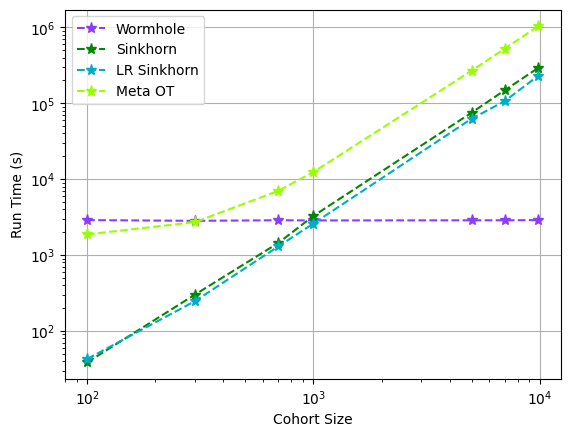

In [53]:
palette = {'Wormhole': matplotlib.colormaps.get_cmap('cet_glasbey')(1),
           'Sinkhorn': matplotlib.colormaps.get_cmap('cet_glasbey')(2),
           'LR Sinkhorn': matplotlib.colormaps.get_cmap('cet_glasbey')(3),
           'Meta OT': matplotlib.colormaps.get_cmap('cet_glasbey')(4)}

for name, time in zip(['Wormhole', 'Sinkhorn', 'LR Sinkhorn', 'Meta OT'],
                         [wormhole_times, sinkhorn_times, sinkhorn_lr_times,meta_ot_times]):
    
    time = np.asarray(time)
    plt.plot(np.asarray(scale_sizes), time, label = name, marker = '*', linestyle = '--', markersize = 8, c= palette[name])
    plt.xscale('log')
    plt.yscale('log')

plt.xlabel('Cohort Size', fontdict={'size':10})
plt.ylabel('Run Time (s)', fontdict={'size':10})
plt.legend()
plt.grid()
plt.show()